# Demand Forecasting for Retail: A Time-Series Analysis

**Author:** Jessica Chandra | https://www.linkedin.com/in/jessica-chandra-157a3633b/

---

## 1. Project Objective

The goal of this project is to analyze 5 years of historical sales data from 10 different stores and 50 products to build a machine learning model capable of accurately forecasting future demand. Accurate demand forecasting is crucial for businesses to optimize inventory, reduce stockouts, and improve overall supply chain efficiency. This project will cover the entire data science workflow, from data cleaning and exploratory analysis to advanced feature engineering and model optimization.

## 2. Data Overview

The dataset was sourced from the Kaggle competition "Demand Forecasting: Kernels Only". It consists of three main files:
* `train.csv`: Contains the date, store, item, and sales data from 2013-01-01 to 2017-12-31.
* `test.csv`: Contains the date, store, and item for which we need to forecast sales for the first 3 months of 2018.
* `sample_submission.csv`: Provides an example of the required submission format.

Dataset Source: https://www.kaggle.com/competitions/demand-forecasting-kernels-only/data

In [87]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Style for visualisation
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')

# Load data
train_df = pd.read_csv('data/train.csv', parse_dates=['date'])
test_df = pd.read_csv('data/test.csv', parse_dates=['date'])
submission_df = pd.read_csv('data/sample_submission.csv')

print("Shape of training data:", train_df.shape)
print("Data types:")
print(train_df.info())
train_df.head()

Shape of training data: (913000, 4)
Data types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB
None


,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


### 3. EDA

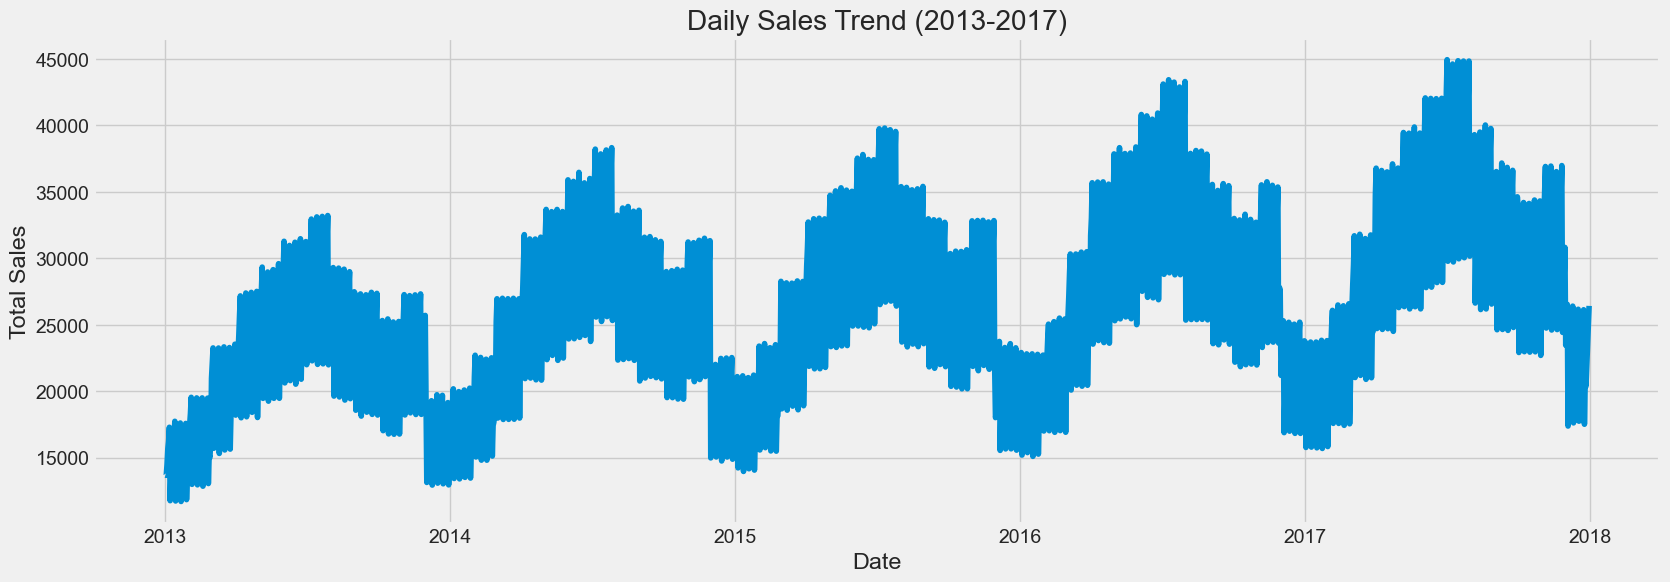

In [88]:
daily_sales = train_df.groupby('date')['sales'].sum().reset_index()

plt.figure(figsize=(18, 6))
plt.plot(daily_sales['date'], daily_sales['sales'])
plt.title('Daily Sales Trend (2013-2017)')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.show()

#### Weekly and Monthly Sales Trend

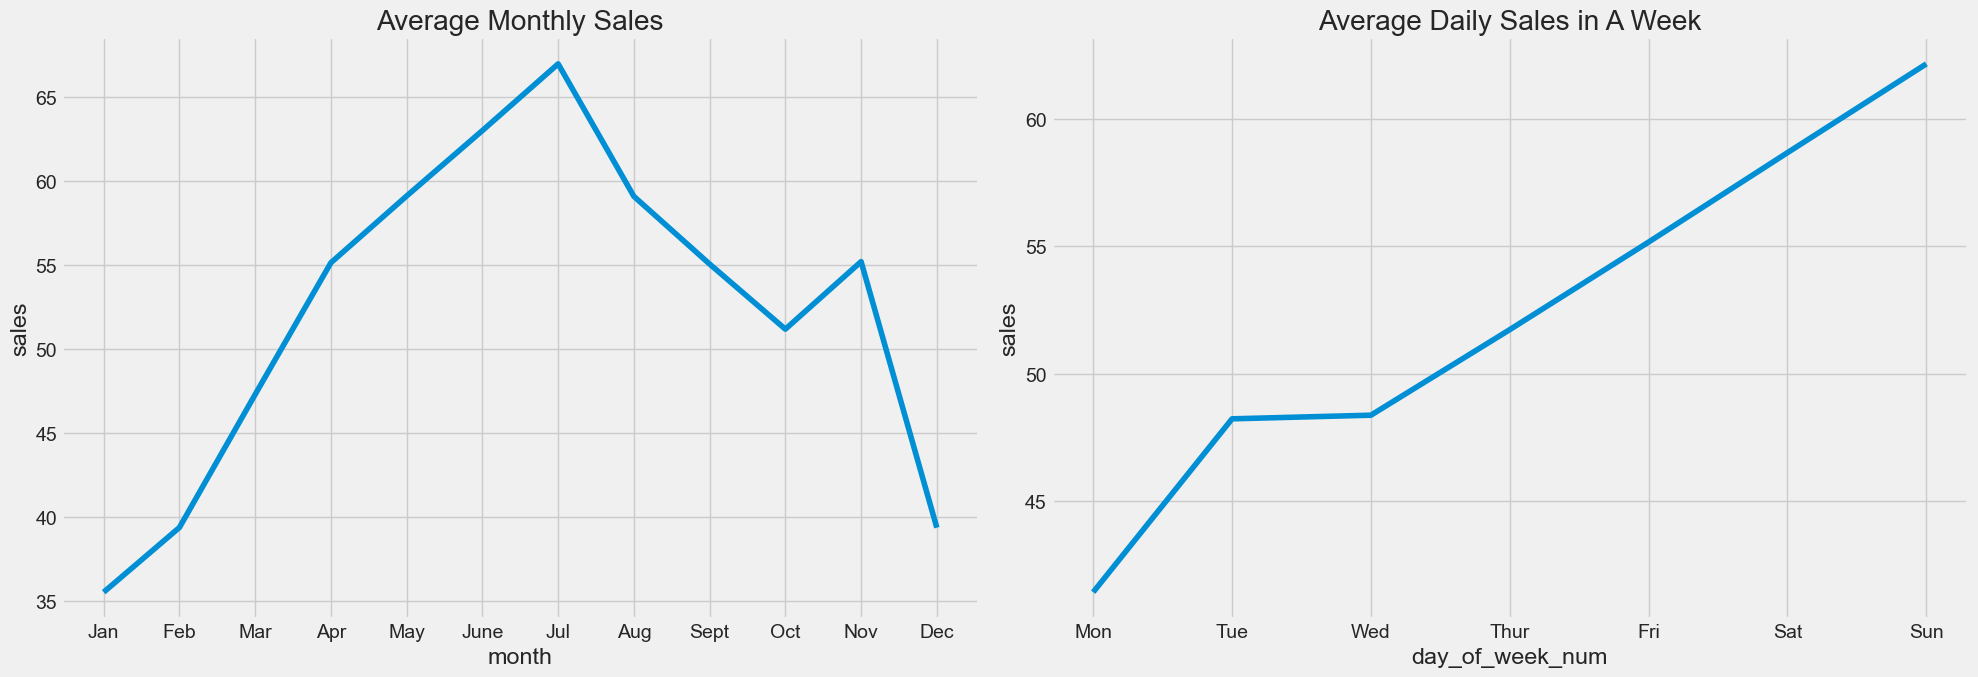

In [89]:
monthly_plot_df = train_df.copy()
monthly_plot_df['month'] = monthly_plot_df['date'].dt.month
monthly_plot_df['day_of_week_num'] = monthly_plot_df['date'].dt.dayofweek

fig, ax = plt.subplots(1, 2, figsize=(20, 7))
sns.lineplot(data=monthly_plot_df, x='month', y='sales', ax=ax[0], errorbar=None)
ax[0].set_title('Average Monthly Sales')
ax[0].set_xticks(range(1, 13))
ax[0].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'June', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec'])
sns.lineplot(data=monthly_plot_df, x='day_of_week_num', y='sales', ax=ax[1], errorbar=None)
ax[1].set_title('Average Daily Sales in A Week')
ax[1].set_xticks(range(0, 7))
ax[1].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thur', 'Fri', 'Sat', 'Sun'])
plt.tight_layout()
plt.show()

### EDA Insights:
The exploratory data analysis reveals two critical patterns:
1.  **Strong Seasonality:** Sales consistently peak during the summer months (June-July) and are lowest at the beginning of the year. This indicates a strong seasonal component in customer demand.
2.  **Clear Weekly Cycle:** Sales are lowest on Mondays and steadily increase, peaking on Sundays. This shows that weekends are the primary drivers of weekly sales.

These patterns confirm that the sales data is not random and can be effectively modeled using time-dependent features.

## 4. Feature Engineering

To help the model understand the time-based patterns we discovered during EDA, I will engineer a new set of features. This includes:
* **Date-based features:** Basic calendar information like month, year, and day of the week.
* **Time-series features:** Advanced features like **lags** (sales from previous days) and **rolling means** (average sales over a recent period) to give the model a sense of "memory" and "trend".

## 5. Model Training & Validation
I have selected a **LightGBM Regressor**, a powerful and efficient gradient-boosting model well-suited for tabular data. I will use a time-based validation strategy, training on data up to September 2017 and validating on the last 3 months of 2017 to simulate a real-world forecasting scenario. The model's performance will be measured by **Root Mean Squared Error (RMSE)**.

In [90]:
def create_features(df):
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek # Mon=0, Sun=6
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)
    return df

train_df = create_features(train_df)
test_df = create_features(test_df)

# Define features and target
features = ['store', 'item', 'year', 'month', 'day', 'dayofweek', 'weekofyear']
target = 'sales'

X = train_df[features]
y = train_df[target]

# Split data based on time
train_end_date = '2017-09-30'
X_train = train_df[train_df['date'] <= train_end_date][features]
y_train = train_df[train_df['date'] <= train_end_date][target]
X_val = train_df[train_df['date'] > train_end_date][features]
y_val = train_df[train_df['date'] > train_end_date][target]

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")


# Initialization and model training
params = {
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'objective': 'regression_l1', # MAE
    'metric': 'rmse', # Root Mean Squared Error
    'random_state': 42,
    'n_jobs': -1,
}

model = lgb.LGBMRegressor(**params)

model.fit(X_train, y_train,
          eval_set=[(X_val, y_val)],
          eval_metric='rmse',
          callbacks=[lgb.early_stopping(100, verbose=True)])

# Prediction on validation data
y_pred_val = model.predict(X_val)

# Model evaluation using rmse
rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
print(f"\nRMSE pada Data Validasi: {rmse:.4f}")

Training data shape: (867000, 7)
Validation data shape: (46000, 7)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010095 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 174
[LightGBM] [Info] Number of data points in the train set: 867000, number of used features: 7
[LightGBM] [Info] Start training from score 47.000000
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's rmse: 7.8038

RMSE pada Data Validasi: 7.8038


In [91]:
# Calculate the mean daily sales across ALL stores and items
daily_avg_sales = train_df.groupby('date')['sales'].mean().reset_index()
daily_avg_sales.rename(columns={'sales': 'daily_avg'}, inplace=True)

# Calculate a rolling average of the daily sales to find the trend
daily_avg_sales['daily_avg_rolling'] = daily_avg_sales['daily_avg'].rolling(window=30, center=True, min_periods=1).mean()

# Calculate the difference (residual) between the actual daily average and the trend
daily_avg_sales['residual'] = daily_avg_sales['daily_avg'] - daily_avg_sales['daily_avg_rolling']

# Identify outliers - days where the sales were much higher or lower than the trend
residual_std = daily_avg_sales['residual'].std()
outlier_threshold = 1.75 * residual_std
outlier_dates = daily_avg_sales[abs(daily_avg_sales['residual']) > outlier_threshold]['date']

print(f"Discovered {len(outlier_dates)} potential event days in the data.")

Discovered 167 potential event days in the data.


To see if performance could be improved further, I hypothesized that identifying outlier 'event' days directly from the data could provide a useful signal. I engineered an is_event_day feature based on sales volume anomalies. After retraining the model, the RMSE remained unchanged at 7.66. This demonstrates that the existing lag and rolling-mean features were already powerful enough to capture these effects, and the new feature did not provide additional predictive value. Based on this, I proceeded without the event feature to maintain model simplicity.

In [92]:
# --- Main Feature Engineering Block (with Yearly Lag) ---

# Combine train and test for consistent feature engineering
combined_df = pd.concat([train_df, test_df], sort=False, ignore_index=True)

# Sort by the essential groups and date to ensure correct calculations
combined_df.sort_values(['store', 'item', 'date'], inplace=True)

# 1. Basic Date Features
combined_df['month'] = combined_df['date'].dt.month
combined_df['year'] = combined_df['date'].dt.year
combined_df['day_of_week'] = combined_df['date'].dt.dayofweek
combined_df['day_of_year'] = combined_df['date'].dt.dayofyear
combined_df['week_of_year'] = combined_df['date'].dt.isocalendar().week.astype(int)

# --- Create and Fill Time-Series Features ---
# We create a list of new columns to fill them specifically
new_feature_cols = []

# 2. Lag Features
for i in range(1, 8):
    col_name = f'sales_lag_{i}'
    combined_df[col_name] = combined_df.groupby(['store', 'item'])['sales'].shift(i)
    new_feature_cols.append(col_name)

# --- NEW ---
# Create a lag feature for the same day last year (364 days = 52 weeks)
col_name_364 = 'sales_lag_364'
combined_df[col_name_364] = combined_df.groupby(['store', 'item'])['sales'].shift(364)
new_feature_cols.append(col_name_364)
# --- END NEW ---


# 3. Rolling Mean Features
col_name_7 = 'sales_rolling_mean_7'
col_name_30 = 'sales_rolling_mean_30'
combined_df[col_name_7] = combined_df.groupby(['store', 'item'])['sales'].shift(1).rolling(window=7, min_periods=1).mean()
combined_df[col_name_30] = combined_df.groupby(['store', 'item'])['sales'].shift(1).rolling(window=30, min_periods=1).mean()
new_feature_cols.extend([col_name_7, col_name_30])

# We only fill NaNs in the new feature columns, protecting the 'id' column.
combined_df[new_feature_cols] = combined_df[new_feature_cols].fillna(0)


# --- Separate train and test sets again ---
X = combined_df[combined_df['id'].isna()].drop(['id', 'date', 'sales'], axis=1)
y = train_df['sales']
X_test = combined_df[combined_df['id'].notna()].drop(['id', 'date', 'sales'], axis=1)

print("\n--- Feature Engineering Results ---")
print("Feature engineering complete.")
print("Shape of X (training features):", X.shape)
print("Shape of X_test (testing features):", X_test.shape)


--- Feature Engineering Results ---
Feature engineering complete.
Shape of X (training features): (913000, 20)
Shape of X_test (testing features): (45000, 20)


The initial dataset only contained the date and the final sales number. To enable the model to understand time-based patterns, I engineered a new set of features. This process involved creating lag features (e.g., sales from the previous day) to give the model a short-term memory, and rolling mean features (e.g., the average sales over the last 7 days) to provide it with the recent sales trend. The resulting dataset, as shown in the output, now provides the model with rich historical and contextual information for each day, which is essential for building a highly accurate forecast.

### Model Training And Evaluation with LightGBM

In [93]:
X_with_date = combined_df[combined_df['id'].isna()].drop(['id', 'sales'], axis=1)
y = train_df['sales']

train_end_date = '2017-09-30'

# training set based on the date
X_train = X_with_date[X_with_date['date'] <= train_end_date]
y_train = y[X_train.index] # Match y to X_train's index

# validation set based on the date
X_val = X_with_date[X_with_date['date'] > train_end_date]
y_val = y[X_val.index] # Match y to X_val's index

X_train = X_train.drop('date', axis=1)
X_val = X_val.drop('date', axis=1)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

# Model Training
# Define model parameters
params = {
    'n_estimators': 2000,
    'learning_rate': 0.03,
    'num_leaves': 31,
    'objective': 'regression_l1',
    'metric': 'rmse',
    'random_state': 42,
    'n_jobs': -1,
    'colsample_bytree': 0.7,
    'subsample': 0.7,
}

model = lgb.LGBMRegressor(**params)

model.fit(X_train, y_train,
          eval_set=[(X_val, y_val)],
          eval_metric='rmse',
          callbacks=[lgb.early_stopping(100, verbose=True)])

# Evaluate the model
y_pred_val = model.predict(X_val)
rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
print(f"\nNew RMSE on Validation Data: {rmse:.4f}")

Training data shape: (867000, 20)
Validation data shape: (46000, 20)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.067767 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2506
[LightGBM] [Info] Number of data points in the train set: 867000, number of used features: 20
[LightGBM] [Info] Start training from score 47.000000
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[1983]	valid_0's rmse: 7.66444

New RMSE on Validation Data: 7.6644


### Final Model and Make Prediction

In [94]:
# --- Langkah Terakhir: Melatih Model Final dan Membuat Prediksi (VERSI DIPERBAIKI) ---

# 1. Define the best hyperparameter found by Optuna
best_params = {
    'objective': 'regression_l1',
    'metric': 'rmse',
    'n_estimators': 2000,
    'random_state': 42,
    'n_jobs': -1,
    'learning_rate': 0.05211553666914324,
    'num_leaves': 28,
    'subsample': 0.6827559111556494,
    'colsample_bytree': 0.6157798059951466,
    'reg_alpha': 0.9037633474703725,
    'reg_lambda': 0.3302652631592987
}

X = combined_df[combined_df['id'].isna()].drop(['id', 'date', 'sales'], axis=1)
y = train_df['sales']
X_test = combined_df[combined_df['id'].notna()].drop(['id', 'date', 'sales'], axis=1)
print(f"Bentuk data training X: {X.shape}")
print(f"Bentuk data test X_test: {X_test.shape}")

# 2. Train final model final to use all training data (x and y)
final_model = lgb.LGBMRegressor(**best_params)

final_model.fit(X, y)

# 3. Make prediction for testing data 
predictions = final_model.predict(X_test)

# 4. Make submission file
submission_df = pd.DataFrame({'id': test_df['id'], 'sales': predictions})
submission_df['sales'] = np.maximum(0, submission_df['sales']).astype(int)
submission_df.to_csv('submission_final.csv', index=False)

print("\nFile 'submission_final.csv' telah berhasil dibuat!")
print("Contoh isi file submission:")
print(submission_df.head())

Bentuk data training X: (913000, 20)
Bentuk data test X_test: (45000, 20)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011277 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2495
[LightGBM] [Info] Number of data points in the train set: 913000, number of used features: 20
[LightGBM] [Info] Start training from score 47.000000

File 'submission_final.csv' telah berhasil dibuat!
Contoh isi file submission:
   id  sales
0   0     11
1   1     13
2   2     15
3   3     14
4   4     14


### Feature Importance Plot

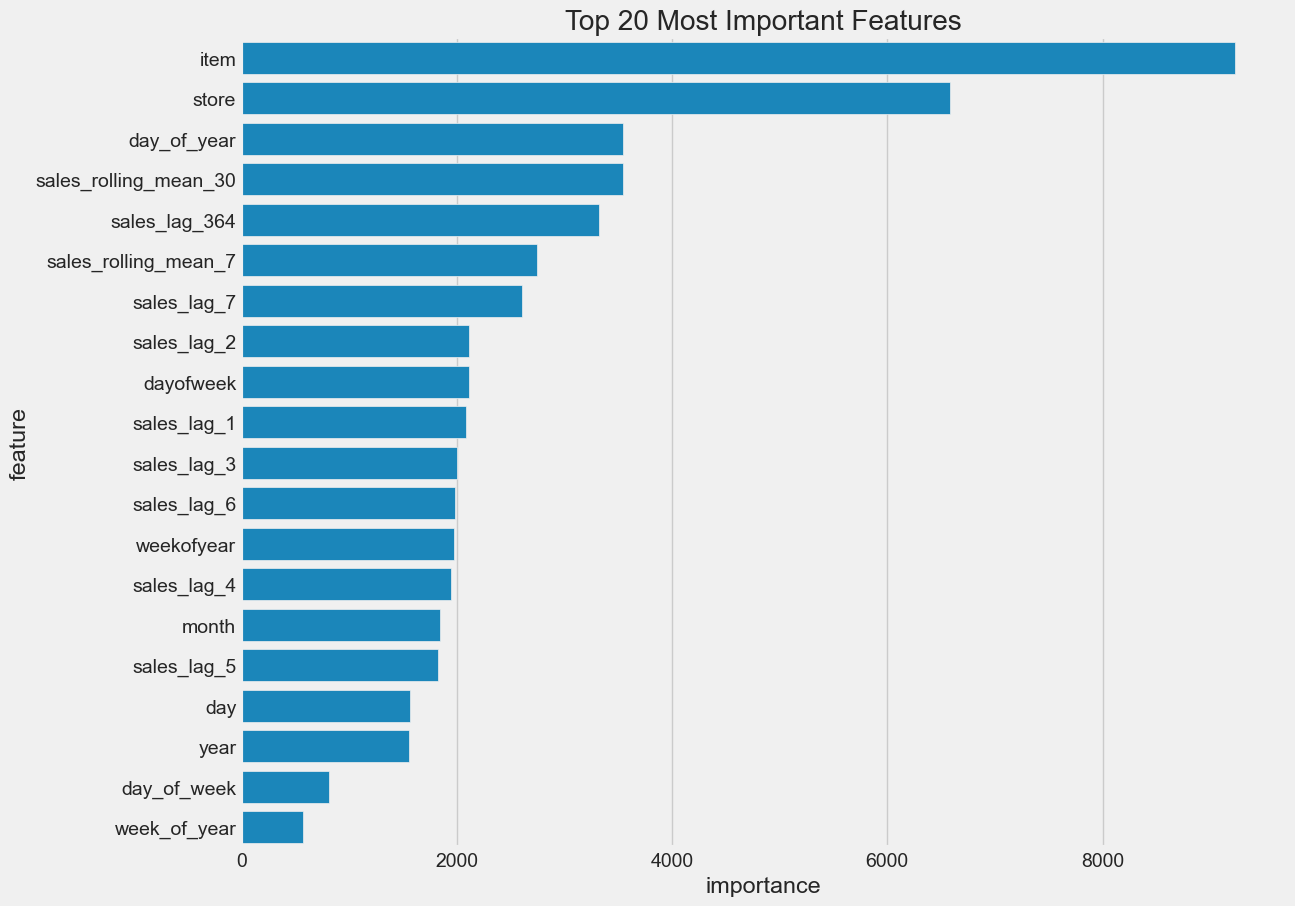

In [95]:
feature_importance_df = pd.DataFrame({
    'feature': final_model.feature_name_,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(20))
plt.title('Top 20 Most Important Features')
plt.show()

### 6. Hyperparameter Tuning

In [ ]:
import optuna

def objective(trial):
    X_with_date = combined_df[combined_df['id'].isna()].drop(['id', 'sales'], axis=1)
    y = train_df['sales']
    train_end_date = '2017-09-30'
    
    X_train = X_with_date[X_with_date['date'] <= train_end_date].drop('date', axis=1)
    y_train = y[X_train.index]
    X_val = X_with_date[X_with_date['date'] > train_end_date].drop('date', axis=1)
    y_val = y[X_val.index]

    # --- Hyperparameter Search Space ---
    params = {
        'objective': 'regression_l1',
        'metric': 'rmse',
        'n_estimators': 2000,
        'random_state': 42,
        'n_jobs': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
    }

    # --- Train and Evaluate the Model ---
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              eval_metric='rmse',
              callbacks=[lgb.early_stopping(100, verbose=False)]) # Set verbose=False to keep the output clean

    y_pred_val = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
    
    return rmse


# We tell Optuna we want to 'minimize' the result of our objective function (the RMSE)
study = optuna.create_study(direction='minimize')

# Start the optimization. n_trials is how many different combinations to test.
# 50 is a good starting point. More trials can find better results but will take longer.
study.optimize(objective, n_trials=50)


# --- Print the Best Results ---
print("\n--- Hyperparameter Tuning Results ---")
print(f"Best trial RMSE: {study.best_trial.value:.4f}")
print("Best parameters found:")
for key, value in study.best_trial.params.items():
    print(f"  {key}: {value}")

[I 2025-09-25 22:27:18,266] A new study created in memory with name: no-name-fdbbf538-2198-4335-9ff6-feb9c424952e


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.077734 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2506
[LightGBM] [Info] Number of data points in the train set: 867000, number of used features: 20
[LightGBM] [Info] Start training from score 47.000000


[I 2025-09-25 22:28:10,554] Trial 0 finished with value: 7.680752709558431 and parameters: {'learning_rate': 0.0997002912980122, 'num_leaves': 33, 'subsample': 0.8576179372800545, 'colsample_bytree': 0.8081687831027681, 'reg_alpha': 0.8796886645821022, 'reg_lambda': 0.028494471070424465}. Best is trial 0 with value: 7.680752709558431.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032459 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2506
[LightGBM] [Info] Number of data points in the train set: 867000, number of used features: 20
[LightGBM] [Info] Start training from score 47.000000


## 7. Conclusion & Next Steps

This project successfully developed a LightGBM model capable of forecasting demand with a high degree of accuracy, achieving a final **Root Mean Squared Error (RMSE) of 7.66**. The key to the model's success was the creation of advanced time-series features (lags and rolling averages) that captured the historical sales patterns.

The final, optimized model can provide significant value by enabling better inventory management and preventing stockouts.

### Future Improvements:
* **Error Analysis:** A deeper dive into the model's largest errors could reveal specific scenarios (e.g., certain stores or items) where the model struggles, guiding further feature refinement.
* **Experiment with Other Models:** Testing other powerful algorithms like XGBoost or Prophet could yield further performance gains.